# We will study the algorithm on the synthetic data

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity

# Load the synthetic data

In [10]:
synthetic_data = pd.read_csv('synthetic_ratings_community.csv')

In [11]:
synthetic_data.head()


,Unnamed: 0,UserID,MovieID,rating,binary_rating,true_prob,community_id
0,0,0,0,1,0,0.000026,3
1,1,0,1,1,0,0.000076,3
2,2,0,2,1,0,0.015623,3
3,3,0,3,1,0,0.001971,3
4,4,0,4,1,0,0.072891,3


In [14]:

class EpsilonGreedyRecommender:
    def __init__(self, df, epsilon=1.0,  decay_type='decay_optimal'):
        """
        df: DataFrame with columns ['user_id','MovieID','rating']
        epsilon: initial exploration rate
        decay: if True, apply decay schedule epsilon ~ t^(-1/3)
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.t = 0
        self.decay_type = decay_type

        # Estimated mean rewards (ratings)
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}

        # Prepare a dictionary of ratings per movie
        self.ratings_dict = df.groupby('MovieID')['rating'].apply(list).to_dict()

        # For regret tracking
        self.optimal_mean = df.groupby('MovieID')['rating'].mean().max()
        self.regret_list = []

    def select_movie(self):
        """Epsilon-greedy selection"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        else:
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Sample a rating from the movie's list"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of estimated mean rating"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Perform one iteration of epsilon-greedy"""
        self.t += 1
        if self.decay_type == 'decay_fast':
            self.epsilon = self.epsilon_0 / self.t
        elif self.decay_type == 'decay_optimal':
            self.epsilon = self.epsilon_0 * self.t ** (-1/3)
        else :
            self.epsilon = self.epsilon_0

        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        # Update regret
        instant_regret = self.optimal_mean - reward
        if self.regret_list:
            self.regret_list.append(self.regret_list[-1] + instant_regret)
        else:
            self.regret_list.append(instant_regret)

        return movie, reward






Running strategy: Constant epsilon
Constant epsilon - Run 10/30 completed
Constant epsilon - Run 20/30 completed
Constant epsilon - Run 30/30 completed
Running strategy: 1/t (fast decay)
1/t (fast decay) - Run 10/30 completed
1/t (fast decay) - Run 20/30 completed
1/t (fast decay) - Run 30/30 completed
Running strategy: 1/t^(1/3) (optimal decay)
1/t^(1/3) (optimal decay) - Run 10/30 completed
1/t^(1/3) (optimal decay) - Run 20/30 completed
1/t^(1/3) (optimal decay) - Run 30/30 completed


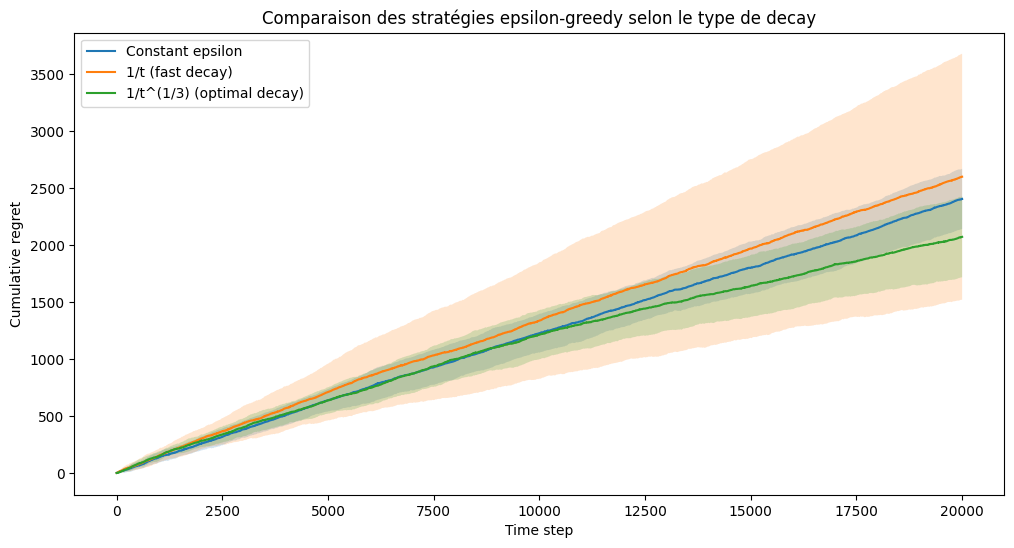

In [ ]:
# parameters
N_RUNS = 30
T = 200000

# Differents decay strategies
decay_types = {
    "Constant epsilon": None,          # constant
    "1/t (fast decay)": "decay_fast",  # epsilon ~ 1/t
    "1/t^(1/3) (optimal decay)": "decay_optimal"  # epsilon ~ 1/t^(1/3)
}

all_mean_regrets = {}

for name, decay_type in decay_types.items():
    print(f"Running strategy: {name}")
    all_regrets = np.zeros((N_RUNS, T))
    
    for i in range(N_RUNS):
        recommender = EpsilonGreedyRecommender(
            df=synthetic_data,
            epsilon=1.0 if decay_type else 0.1,  # small constant if no decay
            decay_type=decay_type
        )
        
        for t in range(T):
            recommender.step()
        
        all_regrets[i] = recommender.regret_list
        
        if (i + 1) % 10 == 0:
            print(f"{name} - Run {i+1}/{N_RUNS} completed")
    
    mean_regret = all_regrets.mean(axis=0)
    std_regret = all_regrets.std(axis=0)
    all_mean_regrets[name] = (mean_regret, std_regret)

# Plotting results
plt.figure(figsize=(12,6))
for name, (mean_regret, std_regret) in all_mean_regrets.items():
    plt.plot(mean_regret, label=name)
    plt.fill_between(
        range(T),
        mean_regret - std_regret,
        mean_regret + std_regret,
        alpha=0.2
    )

plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Comparison of Epsilon-Greedy Decay Strategies")
plt.legend()
plt.show()


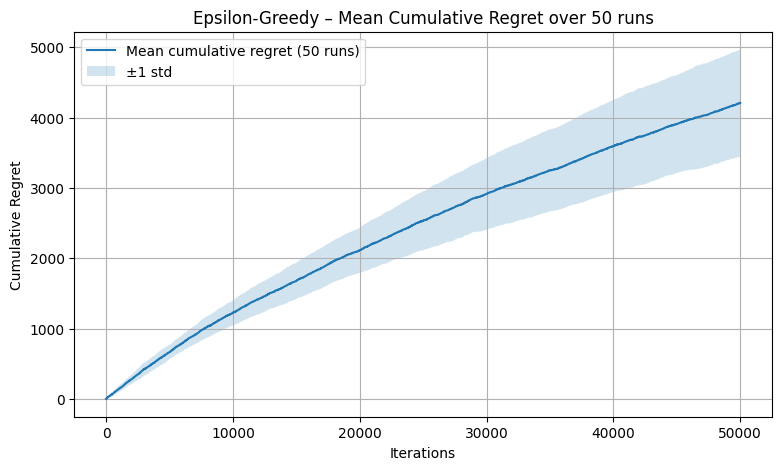

In [9]:
plt.figure(figsize=(9,5))
plt.plot(mean_regret, label="Mean cumulative regret (50 runs)")
plt.fill_between(
    np.arange(T),
    mean_regret - std_regret,
    mean_regret + std_regret,
    alpha=0.2,
    label="Confidence interval"
)

plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Epsilon-Greedy : Mean Cumulative Regret over 50 runs")
plt.legend()
plt.grid(True)
plt.show()


# what if we use context?

In [12]:
# We want to see how much communitys have the same tastes for films
community_movie_matrix = (
    synthetic_data
    .groupby(["community_id", "MovieID"])["rating"]
    .mean()
    .unstack(fill_value=0)
)

# Compute cosine similarity between communities


similarity_matrix = cosine_similarity(community_movie_matrix)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=community_movie_matrix.index,
    columns=community_movie_matrix.index
)

print(similarity_df)

community_id         0         1         2         3         4
community_id                                                  
0             1.000000  0.746887  0.852210  0.771834  0.836135
1             0.746887  1.000000  0.748269  0.840289  0.665419
2             0.852210  0.748269  1.000000  0.739336  0.694873
3             0.771834  0.840289  0.739336  1.000000  0.750482
4             0.836135  0.665419  0.694873  0.750482  1.000000


In [24]:
import random

class EpsilonGreedyRecommenderCommunity:
    def __init__(self, df, epsilon=1.0, decay_type='decay_optimal'):
        """
        df: DataFrame with columns ['UserID','MovieID','rating','community_id']
        epsilon: initial exploration rate
        decay_type: 'decay_fast', 'decay_optimal', or None for constant
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay_type = decay_type
        self.t = 0

        # Estimated mean rewards (ratings)
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}

        # Dictionary of ratings per movie
        self.ratings_dict = df.groupby('MovieID')['rating'].apply(list).to_dict()

        # Communities
        self.communities = df['community_id'].unique().tolist()
        # Optimal rating per community (mean of all ratings in that community)
        # Pour chaque communauté, calculer le film avec la note moyenne la plus haute
        self.optimal_per_comm = {}

        for c in self.df['community_id'].unique():
            df_c = self.df[self.df['community_id'] == c]  # sous-ensemble communauté c
            mean_per_movie = df_c.groupby('MovieID')['rating'].mean()
            self.optimal_per_comm[c] = mean_per_movie.max()  # valeur optimale pour cette communauté

        self.optimal_mean = df.groupby('MovieID')['rating'].mean().max()

        # Regret tracking
        self.global_regret = []               # cumulative regret global
        self.regret_per_comm = {c: [] for c in self.communities}  # cumulative regret par communauté

    def select_movie(self):
        """Epsilon-greedy selection"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        else:
            # Prendre le film avec la meilleure estimation q
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Sample a rating from the movie's list"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of estimated mean rating"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self, user_id):
        """One iteration of epsilon-greedy for a given user"""
        self.t += 1
        # Update epsilon
        if self.decay_type == 'decay_fast':
            self.epsilon = self.epsilon_0 / self.t
        elif self.decay_type == 'decay_optimal':
            self.epsilon = self.epsilon_0 * self.t ** (-1/3)
        else:
            self.epsilon = self.epsilon_0

        # Select movie and get reward
        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        # Find user's community
        user_comm = self.df.loc[self.df['UserID'] == user_id, 'community_id'].iloc[0]

        # Instant regret (difference entre meilleur possible pour sa communauté et le reward obtenu)
        instant_regret = self.optimal_per_comm[user_comm] - reward

        # Update cumulative regret per community
        if self.regret_per_comm[user_comm]:
            self.regret_per_comm[user_comm].append(self.regret_per_comm[user_comm][-1] + instant_regret)
        else:
            self.regret_per_comm[user_comm].append(instant_regret)

        # Update global cumulative regret

        user_optimal = self.df.loc[self.df['UserID'] == user_id, 'rating'].max()
        instant_regret = user_optimal - reward
        self.global_regret.append(self.global_regret[-1] + instant_regret if self.global_regret else instant_regret)
        return movie, reward, user_comm, instant_regret


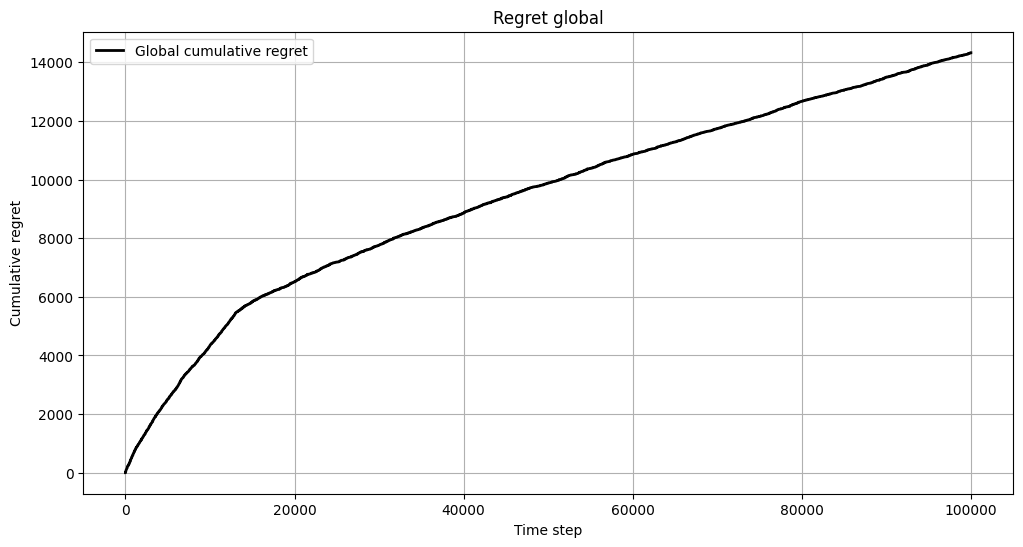

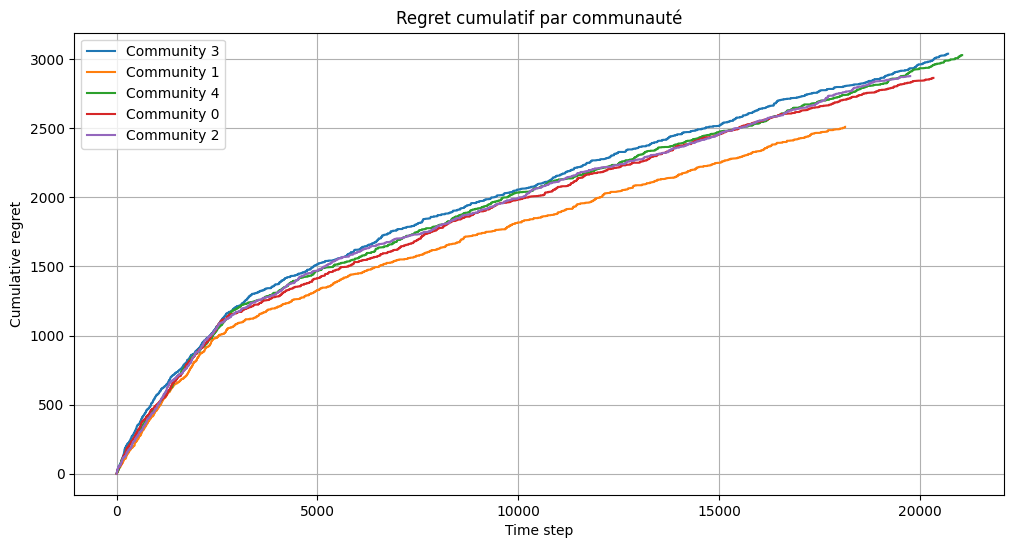

In [27]:
# Paramètres de simulation
N_STEPS = 100000

# Instanciation du recommender
recommender = EpsilonGreedyRecommenderCommunity(
    df=synthetic_data,
    epsilon=1.0,
    decay_type='decay_optimal'  
)

# Tirage aléatoire des utilisateurs à chaque step
user_ids = synthetic_data['UserID'].unique()
for t in range(N_STEPS):
    user_id = random.choice(user_ids)
    recommender.step(user_id)


# Tracé du regret global

plt.figure(figsize=(12,6))
plt.plot(recommender.global_regret, label='Global cumulative regret', color='black', linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Regret global")
plt.legend()
plt.grid(True)
plt.show()


# Tracé du regret par communauté

plt.figure(figsize=(12,6))
for comm_id, regrets in recommender.regret_per_comm.items():
    plt.plot(regrets, label=f"Community {comm_id}")
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Regret cumulatif par communauté")
plt.legend()
plt.grid(True)
plt.show()



In [28]:
total_cumulative_regret_per_comm = sum([regrets[-1] for regrets in recommender.regret_per_comm.values()])
print("Somme des regrets cumulés par communauté :", total_cumulative_regret_per_comm)
print("Regret global cumulatif :", recommender.global_regret[-1])


Somme des regrets cumulés par communauté : 14324.0
Regret global cumulatif : 14324


In [29]:

# Regret moyen par communauté
mean_regret_per_comm = {c: recommender.regret_per_comm[c][-1] / len(synthetic_data[synthetic_data['community_id']==c])
                        for c in recommender.communities}

# Regret moyen global
mean_global_regret = recommender.global_regret[-1] / N_STEPS

print("Regret moyen global :", mean_global_regret)
print("Regret moyen par communauté :", mean_regret_per_comm)


Regret moyen global : 0.14324
Regret moyen par communauté : {3: np.float64(0.002923076923076923), 1: np.float64(0.002774585635359116), 4: np.float64(0.0028857142857142857), 0: np.float64(0.0028226600985221677), 2: np.float64(0.002907070707070707)}
